# Form 4 Processing
We are going to pull all form 4 filings and extract the transactions inside. Then we can use those transactions to uncover what his portfolio was at various times

In [1]:
import requests
import pandas as pd
from secret_services import *

In [2]:
from bs4 import BeautifulSoup


- First we'll parse all forms
- then we'll decide which insiders to prioritize downloading all their submissions

In [3]:
cik="0001494730"#elon musk
url=f"https://data.sec.gov/submissions/CIK{cik}.json"
resp=edgar_get(url)
entity_index=resp.json()
filings=pd.DataFrame(entity_index['filings']['recent'])
filings

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0000899243-21-046681,2021-12-02,2021-12-02,2021-12-02T21:45:11.000Z,34,4,001-34756,211468561,,49785,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
1,0000899243-21-046679,2021-12-02,2021-12-02,2021-12-02T21:43:36.000Z,34,4,001-34756,211468557,,71108,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
2,0000899243-21-045949,2021-11-23,2021-11-23,2021-11-23T21:34:33.000Z,34,4,001-34756,211440983,,36942,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
3,0000899243-21-045947,2021-11-23,2021-11-23,2021-11-23T21:33:26.000Z,34,4,001-34756,211440960,,68179,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
4,0000899243-21-045946,2021-11-23,2021-11-23,2021-11-23T21:32:00.000Z,34,4,001-34756,211440959,,68183,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0001193125-11-023336,2011-02-03,,2011-02-03T17:11:03.000Z,,SC 13G,,,,43579,0,0,dsc13g.htm,SCHEDULE 13G
99,0001181431-11-007124,2011-02-03,2010-06-28,2011-02-03T16:59:39.000Z,34,3/A,001-34756,11570793,,4814,0,0,xslF345X02/rrd299711.xml,FORM 3/A
100,0001494730-11-000002,2011-01-25,2009-12-04,2011-01-25T18:50:24.000Z,34,4,001-34756,11547512,,5799,0,0,xslF345X03/edgardoc.xml,PRIMARY DOCUMENT
101,0001181431-10-035864,2010-07-02,2010-07-02,2010-07-02T14:35:50.000Z,34,4,001-34756,10935566,,25470,0,0,xslF345X03/rrd280655.xml,FORM 4


# Elon Musk Filings

Here's the Edgar website for Elon Musk https://www.sec.gov/edgar/browse/?CIK=0001494730
And we can crossreference on openinsider.com http://openinsider.com/screener?s=&o=0001494730&pl=&ph=&ll=&lh=&fd=730&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=100&page=1 (notice the insider field is the CIK we found earlier)  

I don't really like open insider because it doesn't show me every transaction from an insider. And the ownership values don't always make sense


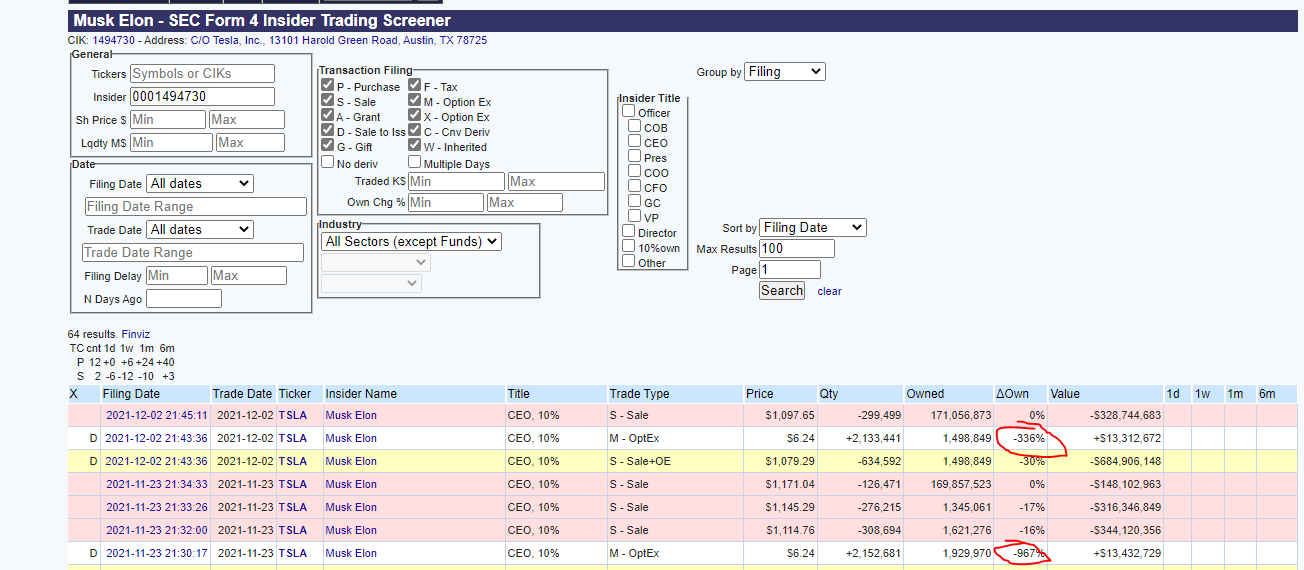  
  
How can you lose 336% ownership and hold a positive amount of shares? Let's see if we can tally this up better and see transaction more from the eyes of the insider. Particularly interesting to see repetitive transactions or the network of insiders and their portfolio companies.

## Form 4 Parser
There are many forms to be parsed, first we'll start with form 4. These appear to be preceded by a form 13 filing requirement stating the initial ownership at time of having an insider public filing requirement.

In [4]:
insider_filings=filings[filings['form'].isin(["3","3/A","4","4/A","5","5/A","SC 13G/A","SC 13D/A","SC 13D","SC 13G"])]
insider_filings

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription
0,0000899243-21-046681,2021-12-02,2021-12-02,2021-12-02T21:45:11.000Z,34,4,001-34756,211468561,,49785,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
1,0000899243-21-046679,2021-12-02,2021-12-02,2021-12-02T21:43:36.000Z,34,4,001-34756,211468557,,71108,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
2,0000899243-21-045949,2021-11-23,2021-11-23,2021-11-23T21:34:33.000Z,34,4,001-34756,211440983,,36942,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
3,0000899243-21-045947,2021-11-23,2021-11-23,2021-11-23T21:33:26.000Z,34,4,001-34756,211440960,,68179,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
4,0000899243-21-045946,2021-11-23,2021-11-23,2021-11-23T21:32:00.000Z,34,4,001-34756,211440959,,68183,0,0,xslF345X03/doc4.xml,FORM 4 SUBMISSION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0001193125-11-023336,2011-02-03,,2011-02-03T17:11:03.000Z,,SC 13G,,,,43579,0,0,dsc13g.htm,SCHEDULE 13G
99,0001181431-11-007124,2011-02-03,2010-06-28,2011-02-03T16:59:39.000Z,34,3/A,001-34756,11570793,,4814,0,0,xslF345X02/rrd299711.xml,FORM 3/A
100,0001494730-11-000002,2011-01-25,2009-12-04,2011-01-25T18:50:24.000Z,34,4,001-34756,11547512,,5799,0,0,xslF345X03/edgardoc.xml,PRIMARY DOCUMENT
101,0001181431-10-035864,2010-07-02,2010-07-02,2010-07-02T14:35:50.000Z,34,4,001-34756,10935566,,25470,0,0,xslF345X03/rrd280655.xml,FORM 4


In [5]:
filing=insider_filings[insider_filings['form']=='4'].iloc[0]
filing

accessionNumber              0000899243-21-046681
filingDate                             2021-12-02
reportDate                             2021-12-02
acceptanceDateTime       2021-12-02T21:45:11.000Z
act                                            34
form                                            4
fileNumber                              001-34756
filmNumber                              211468561
items                                            
size                                        49785
isXBRL                                          0
isInlineXBRL                                    0
primaryDocument               xslF345X03/doc4.xml
primaryDocDescription           FORM 4 SUBMISSION
Name: 0, dtype: object

In [19]:
from bs4 import BeautifulSoup


In [7]:
import lxml.etree as etree

element=etree.XML(resp.text)
etree.indent(element)
print(etree.tostring(element, encoding='unicode'))

<ownershipDocument>
  <schemaVersion>X0306</schemaVersion>
  <documentType>4</documentType>
  <periodOfReport>2021-12-02</periodOfReport>
  <notSubjectToSection16>0</notSubjectToSection16>
  <issuer>
    <issuerCik>0001318605</issuerCik>
    <issuerName>Tesla, Inc.</issuerName>
    <issuerTradingSymbol>TSLA</issuerTradingSymbol>
  </issuer>
  <reportingOwner>
    <reportingOwnerId>
      <rptOwnerCik>0001494730</rptOwnerCik>
      <rptOwnerName>Musk Elon</rptOwnerName>
    </reportingOwnerId>
    <reportingOwnerAddress>
      <rptOwnerStreet1>C/O TESLA, INC.</rptOwnerStreet1>
      <rptOwnerStreet2>13101 HAROLD GREEN ROAD</rptOwnerStreet2>
      <rptOwnerCity>AUSTIN</rptOwnerCity>
      <rptOwnerState>TX</rptOwnerState>
      <rptOwnerZipCode>78725</rptOwnerZipCode>
      <rptOwnerStateDescription/>
    </reportingOwnerAddress>
    <reportingOwnerRelationship>
      <isDirector>1</isDirector>
      <isOfficer>1</isOfficer>
      <isTenPercentOwner>1</isTenPercentOwner>
      <isOther>0

In [29]:
soup.find("issuerTradingSymbol").text

'TSLA'

In [20]:
import tqdm

'0001318605'

In [30]:
from collections import defaultdict
import re
#based off of https://stackoverflow.com/a/10077069
def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k:v[0] if len(v) == 1 else v for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v) for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d

rows=[]
for idx, filing in tqdm.tqdm(insider_filings[insider_filings['form']=='4'].iterrows()):
    doc_url=f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{filing['accessionNumber'].replace('-','')}/{filing['primaryDocument'].split('/')[-1]}"
    resp=edgar_get(doc_url)
    soup=BeautifulSoup(resp.text,"xml")

    for transaction in soup.find_all("nonDerivativeTransaction"):
        rows.append(etree_to_dict(etree.XML(str(transaction)))['nonDerivativeTransaction'])
    for row in rows:
        for tag in ["issuerName","issuerCik","issuerTradingSymbol"]:
            try:
                row[tag]=soup.find(tag).text
            except:
                pass
df=pd.json_normalize(rows, sep='_')
df.columns=[re.sub(r"_value$","",col) for col in df.columns]
df

77it [00:11,  6.87it/s]


,deemedExecutionDate,issuerName,issuerCik,issuerTradingSymbol,securityTitle,transactionDate,transactionCoding_transactionFormType,transactionCoding_transactionCode,transactionCoding_equitySwapInvolved,transactionCoding_footnoteId_@id,...,transactionAmounts_transactionShares_footnoteId_@id,transactionAmounts_transactionPricePerShare,transactionAmounts_transactionPricePerShare_footnoteId_@id,transactionAmounts_transactionAcquiredDisposedCode,postTransactionAmounts_sharesOwnedFollowingTransaction,ownershipNature_directOrIndirectOwnership,ownershipNature_natureOfOwnership,ownershipNature_natureOfOwnership_footnoteId_@id,postTransactionAmounts_sharesOwnedFollowingTransaction_footnoteId_@id,deemedExecutionDate
0,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2021-12-02,4,S,0,F1,...,F2,1090.195,F3,D,1466808,D,NaN,NaN,NaN,NaN
1,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2021-12-02,4,S,0,F1,...,F2,1091.196,F4,D,1442667,D,NaN,NaN,NaN,NaN
2,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2021-12-02,4,S,0,F1,...,F2,1092.247,F5,D,1423132,D,NaN,NaN,NaN,NaN
3,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2021-12-02,4,S,0,F1,...,F2,1093.217,F6,D,1388197,D,NaN,NaN,NaN,NaN
4,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2021-12-02,4,S,0,F1,...,F2,1094.205,F7,D,1365935,D,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2010-07-02,4,C,0,NaN,...,NaN,NaN,F1,A,23322008,I,By trust,NaN,NaN,2010-07-02
661,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2010-07-02,4,C,0,NaN,...,NaN,NaN,F2,A,27022583,I,By trust,NaN,NaN,2010-07-02
662,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2010-07-02,4,X,0,NaN,...,NaN,NaN,F3,A,27136491,I,By trust,NaN,NaN,2010-07-02
663,NaN,TESLA MOTORS INC,0001318605,TSLA,Common Stock,2010-07-02,4,F,0,NaN,...,NaN,17.00,NaN,D,27114763,I,By trust,NaN,NaN,2010-07-02


In [31]:
df.to_csv("musk_transactions.csv",index=False)

## What Data Do We Care About Here?
Always think about the analysis you are doing. I want to know the type of transaction, whether it's an addition or subtraction, price, date, filing date, amount, and which companies. 
  
